# Campaign Email Read Rate Inference and Prediction #

## Preparation ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plotting
import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [2]:
working_dir = "..."
df = pd.read_csv(working_dir+'assessment_challenge.csv', index_col=0)

In [3]:
print("dataframe shape: {}".format(df.shape))
print("\n")
print("preview:\n{}".format(df.head()))
print("\n")
print("summary:\n{}".format(df.describe()))
print("\n")
print("categorical variable counts:")
print(df[['from_domain_hash', 'Domain_extension', 'day']].nunique())
print("\n")
print("columns with at least 1 NaN value: \n{}".format(df.columns[df.isna().any()].tolist()))

dataframe shape: (59976, 18)


preview:
    read_rate                  from_domain_hash Domain_extension  day  \
id                                                                      
1    0.142857  27b0d9f2946586e2714e3b4312bc8207               br  Sat   
2    0.000000  b10a5c38ffad692959a42353fd2896f2              com  Wed   
3    0.500000  f8a9fa3e4cbeb4436c4eaf9183df2cbf              com  Fri   
4    0.134615  6dc9420f4bcb2746186f64cf5072d1fa              com  Sun   
5    0.000000  a37f0e9827536a9bb709b1b505d57aa9              com  Sun   

    campaign_size  unique_user_cnt  avg_domain_read_rate  \
id                                                         
1            14.0             14.0              0.090180   
2            39.0             39.0              0.005406   
3            18.0              2.0              0.302676   
4            52.0             52.0              0.141473   
5            17.0             17.0              0.018936   

    avg_domain_inbox_rate  

Observations:
* `campaign_size` and `unique_user_cnt` have <100 interquartile ranges and also some extremely large values. A campaign that targets 100k+ users seems reasonable in a business sense: for example, in 2016 Amazon was reported to have 310 million active customers; even to target a small fraction of their customer base would easily make a 100k+ campaign. On the other hand, these extreme values can be an indicator of some bug in the record-keeping system. To be safe I would alert the corresponding software engineer to double-check if I noticed this in real work. Within the scope of this analysis, numercial problems become a concern; if we are about to perform feature scaling we need to consider separating those large campaigns or removing them as outliers. 
* Hashed domain name and domain extension have high cardinality. I would consider feature-hashing the former expecting ~5% collison if we decided to include it in the analysis. The latter could be binned or go with a combination of binning and encoding. 
* Average read rate is ~9%, which is higher than what I thought the industry standard was. Its median, 1.7%, suits my expection. I will check its skewness. 
* Almost all columns have 1+ missing value so we need to do some cleaning. 

### Cleaning ###

In [4]:
df[df['Domain_extension'].isnull()==True]

,read_rate,from_domain_hash,Domain_extension,day,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
id,,,,,,,,,,,,,,,,,,
4385,0.000000,33e7a3252c0fd11a89b2224e626d24aa,NaN,Tues,85.0,85.0,0.000000,0.019231,0.087548,0.0,0.117647,0.200000,0.258824,0.105882,0.0,0.141176,0.176471,0.0
28065,0.000000,35ce1d4eb0f666cd136987d34f64aedc,NaN,Wed,11.0,2.0,0.000000,0.000000,0.001859,0.0,0.000000,0.909091,0.090909,0.000000,0.0,0.000000,0.000000,0.0
35495,0.000000,35ce1d4eb0f666cd136987d34f64aedc,NaN,Tues,11.0,2.0,0.000000,0.000000,0.001859,0.0,0.000000,0.909091,0.090909,0.000000,0.0,0.000000,0.000000,0.0
53958,0.000000,8e78e2098cfa0c3b4d7873ba32ee2e81,NaN,Mon,14.0,14.0,0.027778,0.027778,0.057472,0.0,0.000000,0.214286,0.214286,0.357143,0.0,0.142857,0.071429,0.0
59976,0.058333,86d0399a308ae0a71e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.dropna(axis=0)
# print(df.isnull().values.any())
print("dataframe shape after removing records with missing data: {}".format(df.shape))

dataframe shape after removing records with missing data: (59971, 18)


## EDA ##

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


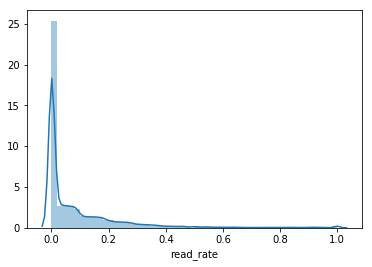

In [6]:
sns.distplot(df['read_rate'])

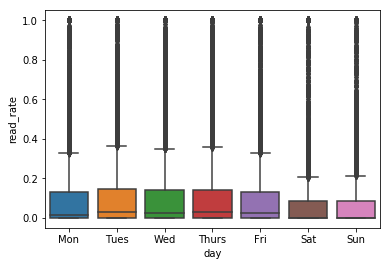

In [7]:
sns.boxplot(x='day', y='read_rate', data=df, order=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

Observations: 
* Read rate is extremely right-skewed. 
* Across weekdays read rate is similar to each other. Between weekend days read rate is similar to each other but weekday read rate is higher. 

A domain that bombards users with emails is likely to be recognized - either by the user themselves or the user's email service provider - as a spam distributer and therefore the campaign email will not be read. First we look at domains that host many campaigns.

In [8]:
domain_hash_freq = pd.Series(df["from_domain_hash"].value_counts())

In [9]:
print("distribution of count of campaigns per domain: \n{}".format(domain_hash_freq.describe()))
print("\n")
print("largest # of campaigns: \n{}".format(domain_hash_freq.nlargest()))
print("\n")
print("98%, 98.5%, 99%, 99.5% percentile of said frequency: \n{}"\
      .format(domain_hash_freq.quantile([.98, .985, .99, .995])))

distribution of count of campaigns per domain: 
count    25477.000000
mean         2.353927
std         27.622361
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       2461.000000
Name: from_domain_hash, dtype: float64


largest # of campaigns: 
50cd1a9a183758039b0841aa738c3f0b    2461
f74d39fa044aa309eaea14b9f57fe79c    2152
d30663cb0bed60805ad3ae4ebbad217b    2148
636ae4d78ec2b46248fc59ac1ad737df    1665
f54db463750940e0e7f7630fe327845e     467
Name: from_domain_hash, dtype: int64


98%, 98.5%, 99%, 99.5% percentile of said frequency: 
0.980    10.0
0.985    14.0
0.990    20.0
0.995    30.0
Name: from_domain_hash, dtype: float64


Similarly, if one campaign (regardless of domain) sends out many email to the same user, it is also likely to be considered spam. Let's look at email count per campaign. 

In [10]:
avg_email_per_unique_user = df['campaign_size'] / df['unique_user_cnt']
print("distribution of frequency of emails per campaign: \n{}".format(avg_email_per_unique_user.describe()))
print("98%, 98.5%, 99%, 99.5% percentile of said frequency: \n{}"
      .format(avg_email_per_unique_user.quantile([.98, .985, .99, .995])))

distribution of frequency of emails per campaign: 
count    59971.000000
mean         2.667014
std         30.475234
min          1.000000
25%          1.000000
50%          1.000000
75%          1.004167
max       4926.000000
dtype: float64
98%, 98.5%, 99%, 99.5% percentile of said frequency: 
0.980    15.000000
0.985    20.000000
0.990    28.000000
0.995    52.433333
dtype: float64


Observations: 75%+ domains host 1 campaign; 75% campaigns send 1 email to each user. Are the outliers erroneous records? I would like to check with the corresponding engineers. 

Among all the features, the simplest to control and act on is campaign size. How is its relationship with the target and other features?

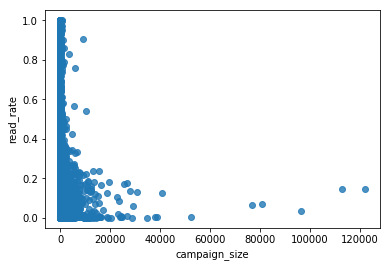

In [74]:
sns.regplot(df['campaign_size'], df['read_rate'], fit_reg=False)

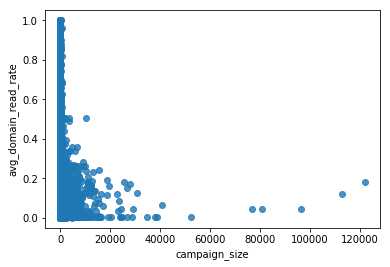

In [73]:
sns.regplot(df['campaign_size'], df['avg_domain_read_rate'], fit_reg=False)

Some campaigns have read rates that are higher than industry standards by far. Anything in common among them?

In [78]:
df[df['read_rate']>=0.8].describe()

,read_rate,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,0.927776,54.876529,31.490545,0.355878,0.684611,0.337238,0.613376,0.417247,0.378730,0.097837,0.056635,0.001448,0.011328,0.021579,0.002960
std,0.067993,341.960709,168.455498,0.219408,0.206396,0.206759,0.296469,0.315672,0.284851,0.154798,0.112331,0.009407,0.058463,0.073217,0.050315
min,0.800000,11.000000,1.000000,0.003285,0.007461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.866667,13.000000,3.000000,0.263610,0.549274,0.212367,0.479792,0.176471,0.157072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.933333,17.000000,11.000000,0.263610,0.632892,0.292640,0.677325,0.363636,0.375000,0.056818,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,29.000000,19.000000,0.490242,0.893216,0.411478,0.827187,0.571429,0.529663,0.133333,0.076923,0.000000,0.000000,0.000000,0.000000
max,1.000000,9237.000000,4260.000000,1.000000,1.000000,0.996852,1.000000,1.000000,1.000000,1.000000,1.000000,0.115385,1.000000,1.000000,1.000000


Most of them are moderately-sized. 

In [81]:
df[(df['read_rate']>=0.8) & (df['campaign_size']>9000)]

,read_rate,from_domain_hash,Domain_extension,day,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
id,,,,,,,,,,,,,,,,,,
4851,0.905489,50cd1a9a183758039b0841aa738c3f0b,com,Sun,9237.0,4260.0,0.26361,0.549274,0.338275,0.682346,0.44442,0.378701,0.082095,0.052489,0.000759,0.018762,0.020063,0.002711


A 90%+ read rate appears unrealistically high. I would like to talk to fraud department to learn more about our data integrity measures. 

## Feature Engineering ##

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("read_rate", axis=1), df["read_rate"], test_size = 0.33,\
                                                    random_state=0)

In [70]:
print("domain extension frequency table: \n{}".format(X_train['Domain_extension'].value_counts().describe()))
print("\n")
print("domains with highest frequencies: \n{}".format(X_train['Domain_extension'].value_counts().nlargest()))

domain extension frequency table: 
count      371.000000
mean       108.301887
std       1501.647389
min          1.000000
25%          2.000000
50%          5.000000
75%          9.000000
max      28759.000000
Name: Domain_extension, dtype: float64


domains with highest frequencies: 
com     28759
info     2237
net      1903
org      1119
br        943
Name: Domain_extension, dtype: int64


The top 5 most common domains plus two that I intuitively think are more likely to be read are kept as separate levels; less common levels are combined into one. 

In [14]:
domain_select = ["com", "info", "net", "org", "br", "edu", "gov"]
X_train['domain_type'] = X_train['Domain_extension'].apply(lambda x: x if x in domain_select else 'other')
X_test['domain_type'] = X_test['Domain_extension'].apply(lambda x: x if x in domain_select else 'other')

In [15]:
def encode_feature(feature_name):
    # globals()[df_name]
    global X_train, X_test
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(X_train[feature_name])
    orig_levels = list(X_train[feature_name].unique())
    # dictionary: encoded level: original level
    col_name = dict(zip(label_encoder.transform(orig_levels),\
                    label_encoder.inverse_transform(label_encoder.transform(orig_levels))))
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    X_train = pd.concat([X_train.reset_index(), pd.DataFrame(onehot_encoded)], axis=1).set_index('id')
    X_train.rename(columns=col_name, inplace=True)

    del integer_encoded, onehot_encoded 

    integer_encoded = label_encoder.transform(X_test[feature_name])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)

    X_test = pd.concat([X_test.reset_index(), pd.DataFrame(onehot_encoded)], axis=1).set_index('id')
    X_test.rename(columns=col_name, inplace=True)

    # merge_rename(X_test)

    del integer_encoded, onehot_encoded 

encode_feature('domain_type')
encode_feature('day')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
predictors = ['campaign_size', 'unique_user_cnt', 'avg_domain_read_rate', 'avg_domain_inbox_rate',
              'avg_user_avg_read_rate', 'avg_user_domain_avg_read_rate', 'mb_superuser', 'mb_engper',
              'mb_supersub', 'mb_engsec', 'mb_inper', 'mb_insec', 'mb_unengsec', 'mb_idlesub',
              'br', 'com', 'edu', 'gov', 'info', 'net', 'org', 'other', 'Fri', 'Mon', 'Sat', 'Sun',
              'Thurs', 'Tues', 'Wed']

Thoughts: Suppose I one-hot-encode hashed domain name, then domains that only exist in the test set (or new domains that were never seen before, in practice) will not be encoded. Suppose I feature-hash it to be future-proof, a feature space that is 26k (# of unique values of `from_domain_hash` is 25481) with 5% collison means the size of the hashing space will be 0.5 million. Therefore hashed domain name is not included in the analysis due to computation difficulty. 

## Model Building ##

### Random Forest Regression ###

Random Forest is a great go-to model for a data challenge. It is robust to outliers and skewed distributions in explanatory, does not require feature scaling, is not demanding on hyperparameter tuning (unlike SVM), and does not easily overfit (unlike boosted tree methods). 

We notice that the dependent variable is highly right-skewed. It also has many 0's so we cannot use a log transformation. Take the square root. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


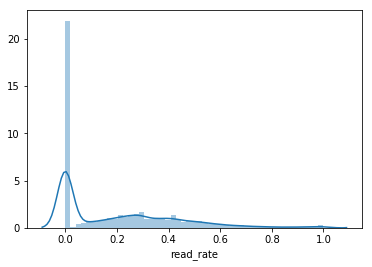

In [18]:
y_train_t = np.sqrt(y_train)
sns.distplot(y_train_t)

Still looks very skewed. However the data now looks like a better-behaved bimodal distribution. 

In [52]:
rf = RandomForestRegressor(oob_score=True, random_state=0, max_features=0.33)
rf.fit(X_train[predictors], y_train_t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.33, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

### Plotting the Predictions ###

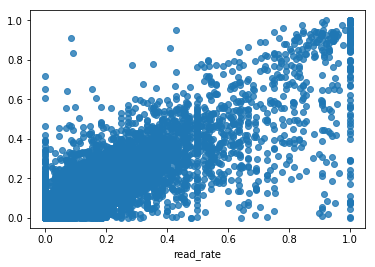

In [21]:
predicted = rf.predict(X_test[predictors])**2
sns.regplot(y_test, predicted, fit_reg=False)

In [22]:
print('Training OOB error rate: {0:0.4f}'.format(1 - rf.oob_score_))

Training OOB error rate: 0.2907


The performance of the Random Forest model is less than satisfactory. It is not a surprise though given the highly skewed response variable. I have read that in this case the problem becomes a mixture model, or, more practically, a classification. In an interview I would stop the modeling building process here and move on to variable importance. In a real-life project I would separate the data at the global median of `read_rate` and then treat them as two independent datasets for analysis. Note that using the global median, which is calculated based on both training and testing data, causes leakage and will impact model performance; I am not very concerned about the magnitude of this impact. 

Feature importance:
campaign_size = 0.0176
unique_user_cnt = 0.0171
avg_domain_read_rate = 0.2047
avg_domain_inbox_rate = 0.0960
avg_user_avg_read_rate = 0.1314
avg_user_domain_avg_read_rate = 0.3743
mb_superuser = 0.0307
mb_engper = 0.0264
mb_supersub = 0.0163
mb_engsec = 0.0141
mb_inper = 0.0080
mb_insec = 0.0264
mb_unengsec = 0.0136
mb_idlesub = 0.0014
br = 0.0004
com = 0.0026
edu = 0.0002
gov = 0.0002
info = 0.0003
net = 0.0011
org = 0.0009
other = 0.0017
Fri = 0.0020
Mon = 0.0020
Sat = 0.0021
Sun = 0.0021
Thurs = 0.0022
Tues = 0.0021
Wed = 0.0022


Plotting feature importance:


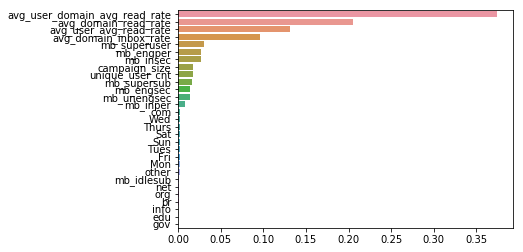

In [23]:
print("Feature importance:")
for name, importance in zip(predictors, rf.feature_importances_):
    print(name, "=", "{0:0.4f}".format(importance));
print("\n")

print("Plotting feature importance:")
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
ax = sns.barplot(x=importances[indices], y=np.array(predictors)[indices])

`avg_user_domain_avg_read_rate` is the most important predictor. Unfortunately none of the top 3 most important features is directly actionable. I would re-build the model without those features and then re-check variable importance. 

However, that `avg_domain_read_rate` is an important predictor tells us that carrying out the campaign on a domain with high average read rate might lead to a higher read rate for a particular campaign. It might appear that I have reversed the cause and the effect - it is possible that the "successful" domain only hosts high-quality campaigns and then those campaigns drive up the overall read rate of that domain, rather than that putting any campaign on a certain domain will magically increase the read rate. Having realized that, successful domains may have special optimization strategies to improve campaign performance. Domain knowledge (no pun intended) is required to understand the causal relationship. 

### Partial Dependence Plots ###

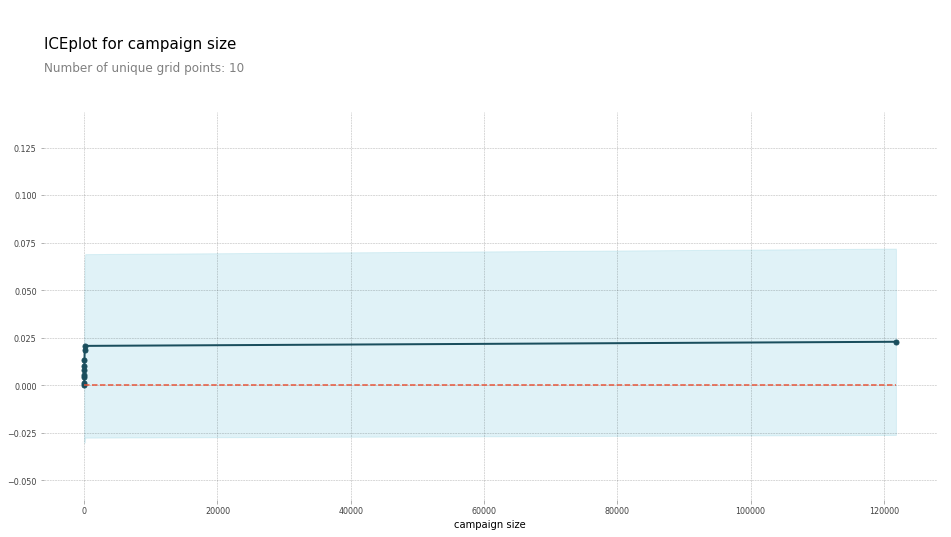

In [71]:
pdp_plot(pdp_isolate(rf, X_train[predictors], 'campaign_size'), 'campaign size')
plt.show()

## Conclusions and Suggestions ##
* Some domains are working better than others. We could implement campaigns on those domains to take advantage of such benefit. 
* Certain campaigns are more successful than other by far. Case reviews are helpful in such case. 